In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import geopandas
from datetime import date
from matplotlib.colors import ListedColormap
from mpl_toolkits.axes_grid1 import make_axes_locatable

%run ../global_variables.py ./
%run ../global_functions.py ./

world = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))
world.drop([159,22,23],inplace=True) # Antarctica, Greenland,Seven seas (tiny islands Indian ocean)

This notebook allows individual runs for each dataset (parts 1 and 2) as well as the computation of the water budget for given datasets. 

Load basins data : 
- `RASTAREA` is the basin area in km^2
- `MAIN_CLIMATE` is the Koppen-Geiger climate zone covering the largest part of the basin
- `CLIMATE_AREA_%` is the area percentage covered by the main climate

In [2]:
#basins=load_basins_data(approximate=False)
basins=geopandas.read_file("../datasets/basins/basins_with_climate_zones.shp")
basins.set_index("NAME",inplace=True)
basins.drop(['CONTINENT', 'OCEAN', 'CLIMATE_AR','COLOR_HEX'],axis=1,inplace=True)
basins.columns=['RASTAREA','MAIN_CLIMATE','geometry']
basins

,RASTAREA,MAIN_CLIMATE,geometry
NAME,,,
WINISK,65635.3,Dfc,"POLYGON ((-87.24167 52.32500, -87.24223 52.314..."
COPPER,65704.3,Dfc,"POLYGON ((-140.15833 61.00000, -140.15890 60.9..."
NOTTAWAY,66053.1,Dfc,"MULTIPOLYGON (((-73.85417 50.00833, -73.85089 ..."
TALAS,66179.8,BSk,"POLYGON ((73.61250 42.33333, 73.60612 42.33277..."
MARONI,66408.4,Afm,"POLYGON ((-53.08750 3.20833, -53.08508 3.20798..."
...,...,...,...
Tibetan plateau,590841.4,ET,"POLYGON ((91.41667 35.80000, 91.51172 35.76596..."
Western Plateau,1998005.0,BWh,"POLYGON ((134.56667 -16.38750, 134.62917 -16.4..."
Puna de Atacama plateau,101842.2,ET,"MULTIPOLYGON (((-68.88750 -26.79167, -68.83750..."


<IPython.core.display.Javascript object>


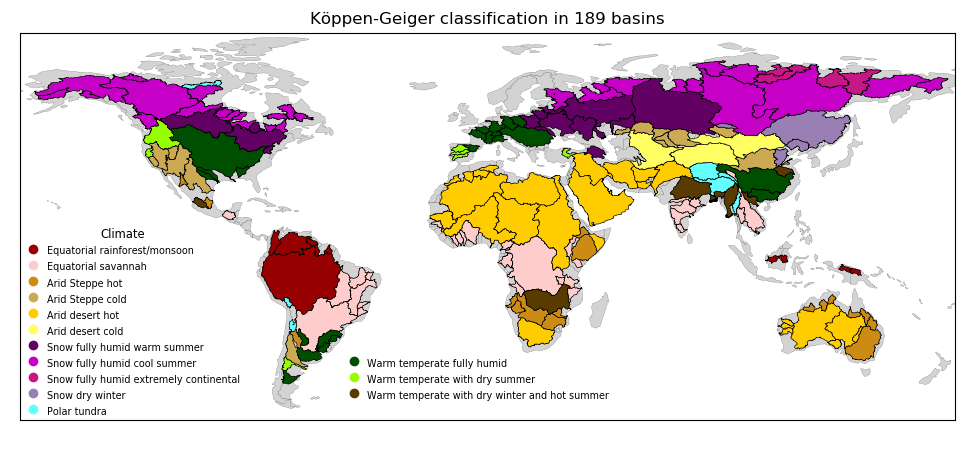

In [11]:
%matplotlib notebook

fig, ax = plt.subplots(figsize=(9.7,4.5))
ax.set_aspect('equal')

world.plot(ax=ax,color='lightgrey',edgecolor='black',linewidth=0.1)

#plt.fill([-165,-83,-83,-165],[-59,-59,15,15],'white')
plt.text(-140,8,'Climate',fontsize='small')

i=2
j=-40
k=-55
for label in np.unique(basins['MAIN_CLIMATE']):
    label_name=climate_name_dict[label]
    color=climate_color_dict[label]
    basins.loc[basins['MAIN_CLIMATE']==label].plot(ax=ax,edgecolor='black',linewidth=0.4,
                                                  facecolor=color)
    if label[0]!='C' and i>-60:
        plt.scatter(-165,i+2,color=color)
        plt.text(-160,i,label_name,fontsize='x-small')
        i-=6
    elif j>-60:
        plt.scatter(-45,j+2,color=color)
        plt.text(-40,j,label_name,fontsize='x-small')
        j-=6
    else:
        plt.scatter(65,k+2,color=color)
        plt.text(70,k,label_name,fontsize='x-small')
        k-=6
#ax.set_facecolor("azure")
ax.set_xticks([])
ax.set_yticks([])
ax.set_xlim([-170,180])
ax.set_ylim([-60,85])
ax.set(title='Köppen-Geiger classification in {} basins'.format(basins.shape[0]))
fig.tight_layout()
plt.show()

# 1. Gridded hydrological variables

## 1.1. Load data

Load the spatial grid where variables are available (`spatial_grid`).

`hydro_grid` is a DataFrame with each row representing a cell grid and each column is a month

`time_hydro` is the set of months when the current variable is known

- For precipitations (`'P'`) choose among : `'CPC'`, `'CRUN'`, `'GPCC'`, `'GPCP'`, `'GPM'`, `'TRMM'`, `'ERA5_Land'`, `'MERRA2'`, `'JRA55'`, `'GLDAS20'`, `'MSWEP'`

- For evapotranspiration (`'ET'`) choose among : `'GLDAS20_NOAH36'`, `'GLDAS20_CLSM25'`, `'GLDAS20_VIC412'`, `'GLDAS21_NOAH36'`, `'GLDAS21_CLSM25'`, `'GLDAS21_VIC412'`, `'GLDAS22_CLSM25'`, `'ERA5_Land'`, `'MERRA2'`, `'JRA55'`, `'SSEBop'`, `'GLEAM'`, `'MOD16'`, `'FLUXCOM'`

- For runoff (`'R'`) choose among `'GLDAS20_NOAH36'`, `'GLDAS20_CLSM25'`, `'GLDAS20_VIC412'`, `'GLDAS21_NOAH36'`, `'GLDAS21_CLSM25'`, `'GLDAS21_VIC412'`, `'GLDAS22_CLSM25'`, `'ERA5_Land'`, `'MERRA2'`, `'JRA55'`, `'GRUN'`

- For water storage (`'TWS'`) choose among `'GRACE_JPL_mascons'`, `'GRACE_CSR_mascons'`, `'GRACE_CSR_grid'`

- For potential evapotranspiration (`'PET'`) choose among `'SSEBop'`, `'CRU'`

In [12]:
hydro_var_name='P'
data='GLDAS20'

(spatial_grid,hydro_grid,time_hydro)=load_hydro_data(hydro_var_name,data,
                            fill_value=dict_fill_value[data],version=version_data[data])

<IPython.core.display.Javascript object>


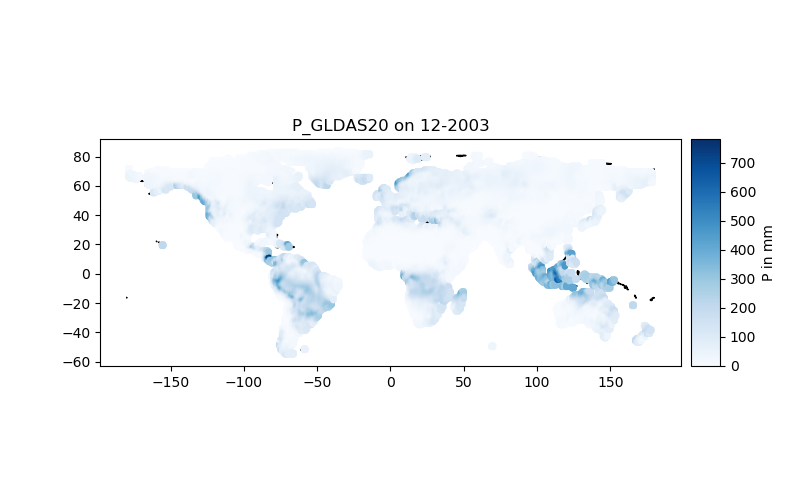

In [13]:
month='12'
year='2003'

norm,cmap=define_cmap(hydro_var_name,hydro_grid['{} {}-{}-15'.format(hydro_var_name,year,month)].values)
fig, ax = plt.subplots(figsize=(8,5))
ax.set_aspect('equal')
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)

world.plot(ax=ax, color='white', edgecolor='black')
hydro_grid.plot(ax=ax,marker='.',column='{} {}-{}-15'.format(hydro_var_name,year,month),
             legend=True,legend_kwds={'label': "{} in mm".format(hydro_var_name)},cax=cax,
            cmap=cmap,norm=norm)

ax.set_title('{}_{} on {}-{}'.format(hydro_var_name,data,month,year))
plt.show()

## 1.2. Select grid points inside a basin

<IPython.core.display.Javascript object>


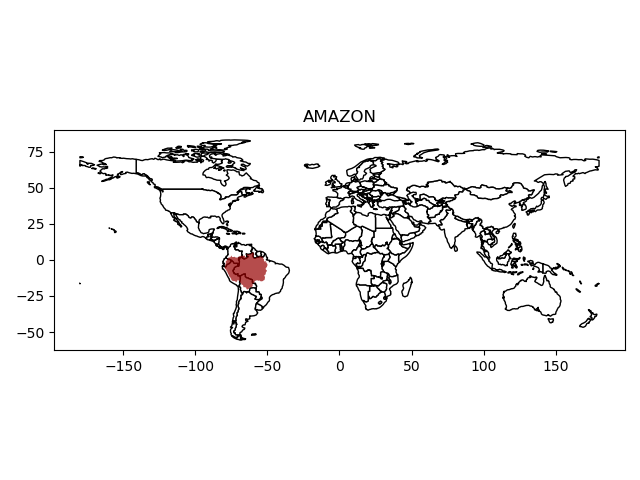

In [17]:
basin_name='AMAZON'

fig, ax = plt.subplots()
ax.set_aspect('equal')
world.plot(ax=ax, color='white', edgecolor='black')
basins.loc[[basin_name],'geometry'].plot(ax=ax, color=climate_color_dict[basins.loc[basin_name,'MAIN_CLIMATE']],alpha=0.7)
plt.title(basin_name)
plt.tight_layout()
plt.show()

To find the grid coordinates loacted inside a given basin, we rely on R-trees (__[reference](https://automating-gis-processes.github.io/site/notebooks/L3/spatial_index.html)__) in the function `find_coordinates_inside_basin`. The method is the following : 

1. we compare the bounds of the Polygon into the spatial index of the Points. This gives us point candidates that are likely to be within the Polygon (at this stage based on the MBR of the points that is stored inside the R-tree). 

1. we go through the candidate points and make a normal spatial intersection query that gives us the accurate results

In [18]:
final_selection=geopandas.read_file("../datasets/basins_grid/{}.shp".format(basin_name))
final_selection.set_index(pd.MultiIndex.from_frame(final_selection[['x','y']]),inplace=True)
hydro_grid.set_index(pd.MultiIndex.from_frame(hydro_grid[['x','y']]),inplace=True)
hydro_basin=final_selection.join(hydro_grid.loc[:,['{} {}'.format(hydro_var_name,d.date()) for d in time_hydro]])
hydro_basin.set_index(np.arange(hydro_basin.shape[0]),inplace=True)

## 1.3. Missing values

For some datasets, there are grid points with no value (lakes, missing observations...). For GRACE, months with missing values are known. 

<IPython.core.display.Javascript object>


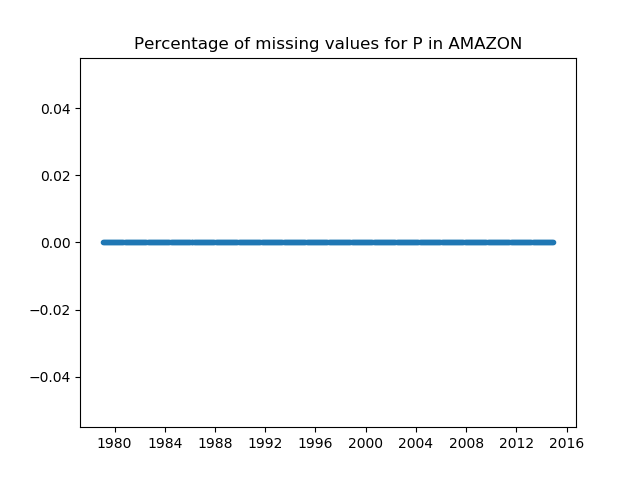

In [19]:
nb_missing_values=hydro_basin.loc[:,['{} {}'.format(hydro_var_name,d.date()) for d in time_hydro]].isna().sum()
perc_missing_values=100*nb_missing_values/final_selection.shape[0]
plt.figure()
plt.plot(time_hydro,perc_missing_values,'.')
plt.title("Percentage of missing values for {} in {}".format(hydro_var_name,basin_name))
plt.show()

If needed, we reconstruct temporal missing values with interpolation (cubic for TWS, linear otherwise). Spatially missing values are ignored in the following function `hydrological_variables_basin_filtered` if they are below a threshold (5%).

In [20]:
if hydro_var_name[:3]=='TWS':
    hydro_basin,filling=my_fillna_temporal(hydro_basin,hydro_var_name,time_hydro,method='cubic')
else:
    hydro_basin,filling=my_fillna_temporal(hydro_basin,hydro_var_name,time_hydro,method='linear')
filling

True

<IPython.core.display.Javascript object>


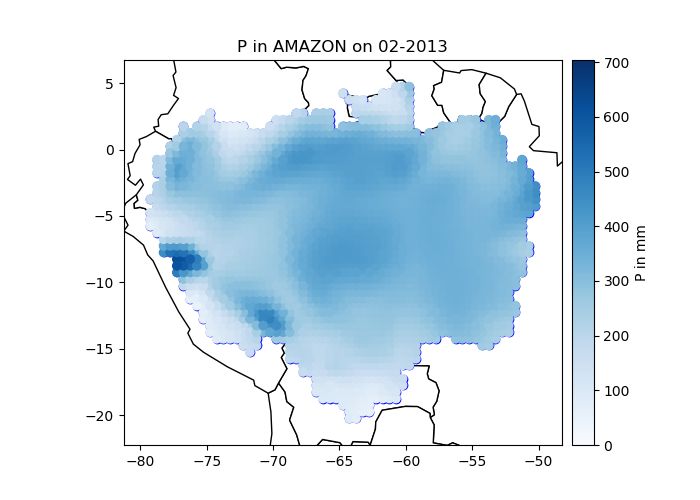

c:\users\fafal\miniconda3\lib\site-packages\geopandas\plotting.py:335: UserWarning: The GeoSeries you are attempting to plot is empty. Nothing has been displayed.
  UserWarning,


In [23]:
year=2013
month='02'

norm,cmap=define_cmap(hydro_var_name,hydro_grid['{} {}-{}-15'.format(hydro_var_name,year,month)].values)

fig, ax = plt.subplots(figsize=(7,5))
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)

world.plot(ax=ax, color='white', edgecolor='black')
hydro_basin.plot(ax=ax, color='white',edgecolor='blue')
hydro_basin.plot(ax=ax,column='{} {}-{}-15'.format(hydro_var_name,year,month),
             legend=True,legend_kwds={'label': "{} in mm".format(hydro_var_name)},cax=cax,
                 missing_kwds={"color": "red",},
            cmap=cmap,norm=norm)
ax.set_xlim([hydro_basin.x.min()-2,hydro_basin.x.max()+2])
ax.set_ylim([hydro_basin.y.min()-2,hydro_basin.y.max()+2])
ax.set_title('{} in {} on {}-{}'.format(hydro_var_name,basin_name,month,year))
plt.show()

## 1.4. Spatial averaging

Sum all grid points and compute the time filtering to match TWS derivation.

In [24]:
hydro_mean_basin, hydro_mean_basin_filter=hydrological_variables_basin_filtered(hydro_basin,hydro_var_name,
                                                                time_hydro,data,version=version_data[data])

<IPython.core.display.Javascript object>


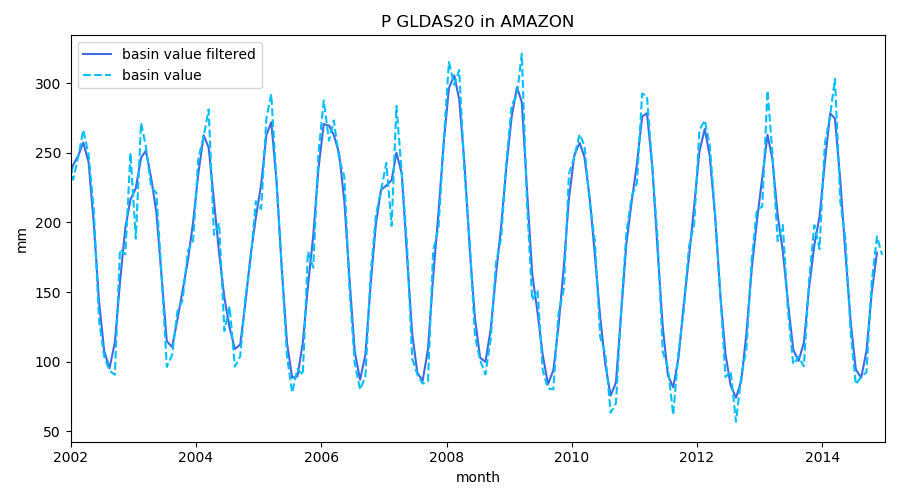

In [26]:
plt.figure(figsize=(9,5))
if hydro_var_name=='TWS': # filtered and unfiltered variables are the same for water storage CHANGES
    plt.plot(time_hydro.iloc[:183],hydro_mean_basin.iloc[:183],'k',label='basin value')
    non_missing_times=pd.to_datetime(perc_missing_values.iloc[:183].loc[perc_missing_values!=100].index.str[4:])
    plt.plot(non_missing_times,hydro_mean_basin.iloc[:183].loc[perc_missing_values!=100],
             'ko',label='observations')
    missing_times=pd.to_datetime(perc_missing_values.iloc[:183].loc[perc_missing_values==100].index.str[4:])
    plt.plot(missing_times,hydro_mean_basin.iloc[:183].loc[perc_missing_values==100],
             'x',color='grey',label='missing data')
else:
    plt.plot(time_hydro[1:-1],hydro_mean_basin_filter,label='basin value filtered',color='royalblue')
    plt.plot(time_hydro,hydro_mean_basin,'--',label='basin value',color='deepskyblue')
plt.legend()
plt.xlim([date(2002,1,1),date(2015,1,1)])
plt.xlabel("month")
plt.ylabel("mm")
plt.title("{} {} in {}".format(hydro_var_name,data,basin_name))
plt.tight_layout()
plt.show()

# 2. Compare datasets

Compare the time series of different datasets as well as the mean monthly cycle.

In [9]:
def compute_annual_hydro_sum(hydro_month,hydro_var_name,data,basin_name,time_overlap):
    hydro_basin=hydro_month.loc[basin_name,['{}_{} {}'.format(hydro_var_name,data,d.date()) for d in time_overlap[:-1]]].to_frame()
    hydro_basin.index=time_overlap[:-1]
    hydro_basin['year']=np.repeat(np.arange(min_year,max_year),12)
    hydro_year=hydro_basin.groupby('year').sum()
    # transform to Series
    hydro_year=pd.Series(hydro_year.values.flatten(),index=hydro_year.index,name=basin_name)
    return hydro_year

def compute_mean_annual_hydro_sum(hydro_month,hydro_var_name,data,basin_name,time_overlap):
    hydro_year=compute_annual_hydro_sum(hydro_month,hydro_var_name,data,basin_name,time_overlap)
    return hydro_year.mean(),hydro_year.std()

In [3]:
basin_name='SEINE'

In [12]:
hydro_var_name='ET'
list_data=['ERA5_Land','GLDAS20_CLSM25','GLDAS21_CLSM25','SSEBop']

In [6]:
hydro_var_name='P'
list_data=['CRU','GPCP','GPCC','GLDAS20']

In [7]:
hydro_var_name='R'
list_data=['GLDAS20_VIC412','GLDAS21_VIC412','GRUN']

In [8]:
hydro_var_name='TWS'
list_data=['GRACE_JPL_mascons','GRACE_CSR_mascons','GRACE_CSR_grid']

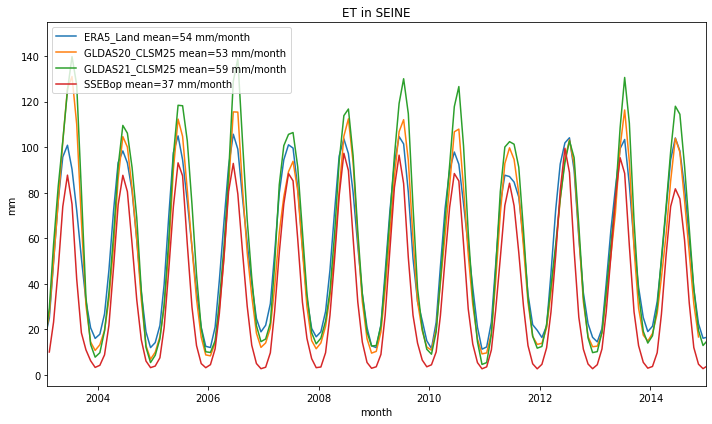

In [5]:
plt.figure(figsize=(10,6))

for data in list_data:
    hydro_month=pd.read_csv('../results/hydrology/{}_{}_monthly_filtered.csv'.format(hydro_var_name,data),
                                                            index_col=[0])
    time_hydro=pd.to_datetime(hydro_month.columns.str[len(hydro_var_name)+1+len(data):])
    plt.plot(time_hydro,hydro_month.loc[basin_name],label='{} mean={:.0f} mm/month'.format(data,hydro_month.loc[basin_name].mean()))
plt.legend(loc='upper left')
plt.title("{} in {}".format(hydro_var_name,basin_name))
plt.xlabel('month')
plt.ylabel("mm")
plt.xlim([date(2003,2,1),date(2015,1,1)])
plt.tight_layout()
plt.show()    

In [20]:
min_year=2004
max_year=2014
month_start=1
time_overlap=pd.date_range(start=date(min_year,month_start,1),end=date(max_year,month_start+1,1),freq='SM')[::2]

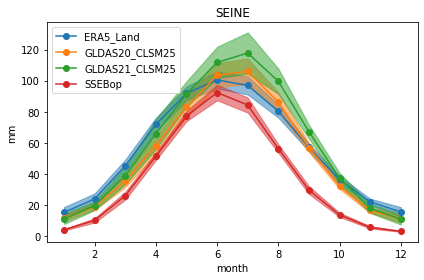

In [21]:
plt.figure()
for i,data in enumerate(list_data):
    hydro_month=pd.read_csv('../results/hydrology/{}_{}_monthly_filtered.csv'.format(hydro_var_name,data),
                                                            index_col=[0])
    hydro_mean,hydro_std=compute_mean_annual_hydro_sum(hydro_month,hydro_var_name,data,basin_name,time_overlap)
    line,=plt.plot(np.arange(1,13),hydro_mean,'-o',label=data)
    plt.fill_between(np.arange(1,13),hydro_mean-hydro_std,hydro_mean+hydro_std,color=line.get_color(),alpha=0.5)
plt.xlabel('month')
plt.ylabel('mm')
plt.title(basin_name)
plt.legend()
plt.tight_layout()
plt.show()

# 3. Components of the annual water cycle

In [3]:
def compute_annual_hydro_sum(hydro_month,hydro_var_name,data,basin_name,time_overlap):
    hydro_basin=hydro_month.loc[basin_name,['{}_{} {}'.format(hydro_var_name,data,d.date()) for d in time_overlap[:-1]]].to_frame()
    hydro_basin.index=time_overlap[:-1]
    hydro_basin['year']=np.repeat(np.arange(min_year,max_year),12)
    hydro_year=hydro_basin.groupby('year').sum()
    # transform to Series
    hydro_year=pd.Series(hydro_year.values.flatten(),index=hydro_year.index,name=basin_name)
    return hydro_year

def compute_mean_annual_hydro_sum(hydro_month,hydro_var_name,data,basin_name,time_overlap):
    hydro_year=compute_annual_hydro_sum(hydro_month,hydro_var_name,data,basin_name,time_overlap)
    return hydro_year.mean(),hydro_year.std()

def compute_annual_hydro_diff(hydro_month,hydro_var_name,data,basin_name,time_overlap):
    hydro_basin=hydro_month.loc[basin_name,['{}_{} {}'.format(hydro_var_name,data,d.date()) for d in time_overlap]]
    hydro_basin.index=time_overlap
    hydro_year=pd.Series(hydro_basin.values[12::12]-hydro_basin.values[:-12:12],index=np.arange(min_year,max_year))
    return hydro_year

def compute_mean_annual_hydro_diff(hydro_month,hydro_var_name,data,basin_name,time_overlap):
    hydro_year=compute_annual_hydro_diff(hydro_month,hydro_var_name,data,basin_name,time_overlap)
    return hydro_year.mean(),hydro_year.std()

In [9]:
selected_basins=basins.copy().drop('Great Basin')

In [10]:
water_cycle_comp=pd.DataFrame(np.zeros((selected_basins.shape[0],4*2)),index=selected_basins.index,
                             columns=['P_mean','P_std','ET_mean','ET_std','R_mean','R_std','TWS_mean','TWS_std'])

In [11]:
data_P='GPCP'
data_ET='GLEAM'
data_R='GRUN'
data_TWS='GRACE_JPL_mascons'

In [12]:
TWS_month=pd.read_csv('../results/hydrology/TWS_{}_monthly.csv'.format(data_TWS),index_col=[0])
time_TWS=pd.to_datetime(TWS_month.columns.str[4+len(data_TWS):])

P_month=pd.read_csv('../results/hydrology/P_{}_monthly.csv'.format(data_P),index_col=[0])
time_P=pd.to_datetime(P_month.columns.str[2+len(data_P):])

ET_month=pd.read_csv('../results/hydrology/ET_{}_monthly.csv'.format(data_ET),index_col=[0])
time_ET=pd.to_datetime(ET_month.columns.str[3+len(data_ET):])

R_month=pd.read_csv('../results/hydrology/R_{}_monthly.csv'.format(data_R),index_col=[0])
time_R=pd.to_datetime(R_month.columns.str[2+len(data_R):]) 

time_idx=pd.date_range(max(time_P.min(),time_ET.min(),time_R.min(),time_TWS.min()),
       min(time_P.max(),time_ET.max(),time_R.max(),time_TWS.max()),
      freq='SM')[::2]

min_year=np.unique(time_idx.year).min()
max_year=np.unique(time_idx.year).max()
month_start=5 # data computed from May to April
time_overlap=pd.date_range(start=date(min_year,month_start,1),end=date(max_year,month_start+1,1),freq='SM')[::2]

In [13]:
for basin_name in selected_basins.index:
    Pmean,Pstd=compute_mean_annual_hydro_sum(P_month,'P',data_P,basin_name,time_overlap)
    ETmean,ETstd=compute_mean_annual_hydro_sum(ET_month,'ET',data_ET,basin_name,time_overlap)
    Rmean,Rstd=compute_mean_annual_hydro_sum(R_month,'R',data_R,basin_name,time_overlap)
    TWSmean,TWSstd=compute_mean_annual_hydro_diff(TWS_month,'TWS',data_TWS,basin_name,time_overlap)

    water_cycle_comp.loc[basin_name,'P_mean']=Pmean
    water_cycle_comp.loc[basin_name,'P_std']=Pstd

    water_cycle_comp.loc[basin_name,'R_mean']=Rmean
    water_cycle_comp.loc[basin_name,'R_std']=Rstd

    water_cycle_comp.loc[basin_name,'ET_mean']=ETmean
    water_cycle_comp.loc[basin_name,'ET_std']=ETstd

    water_cycle_comp.loc[basin_name,'TWS_mean']=TWSmean
    water_cycle_comp.loc[basin_name,'TWS_std']=TWSstd

In [14]:
water_cycle_comp['MAIN_CLIMATE']=selected_basins['MAIN_CLIMATE']
water_cycle_comp['RASTAREA']=selected_basins['RASTAREA']
water_cycle_comp=water_cycle_comp.sort_values(by=['MAIN_CLIMATE','RASTAREA'],ascending=False)

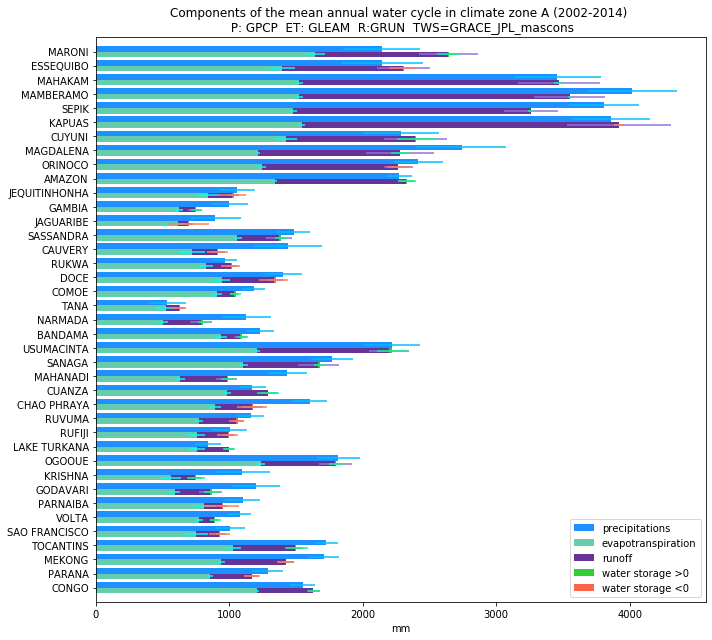

In [20]:
climate='A'
if climate=='all':
    plt.figure(figsize=(10,20))
    water_cycle_comp_selec=water_cycle_comp
    i=water_cycle_comp.shape[0]
else:
    water_cycle_comp_selec=water_cycle_comp.loc[water_cycle_comp['MAIN_CLIMATE'].str[0]==climate]
    i=water_cycle_comp_selec.shape[0]
    plt.figure(figsize=(10,i//4))

height_bar=0.4
plt.barh(np.arange(i)+height_bar/2,water_cycle_comp_selec.loc[:,'P_mean'],
         xerr=water_cycle_comp_selec.loc[:,'P_std'],ecolor='deepskyblue',
         label='precipitations',height=height_bar,color='dodgerblue')

plt.barh(np.arange(i)-height_bar/2,water_cycle_comp_selec.loc[:,'ET_mean'],
         xerr=water_cycle_comp_selec.loc[:,'ET_std'],ecolor='cyan',
         label='evapotranspiration',height=height_bar,color='mediumaquamarine')

plt.barh(np.arange(i)-height_bar/2,water_cycle_comp_selec.loc[:,'R_mean'],
         left=water_cycle_comp_selec.loc[:,'ET_mean'],
         xerr=water_cycle_comp_selec.loc[:,'R_std'],ecolor='mediumpurple',
         label='runoff',height=height_bar,color='rebeccapurple')

plt.barh(np.where(water_cycle_comp_selec['TWS_mean']>0)[0]-height_bar/2,
         water_cycle_comp_selec.loc[water_cycle_comp_selec['TWS_mean']>0,'TWS_mean'],
        left=water_cycle_comp_selec.loc[water_cycle_comp_selec['TWS_mean']>0,'ET_mean']+water_cycle_comp_selec.loc[water_cycle_comp_selec['TWS_mean']>0,'R_mean'],
         xerr=water_cycle_comp_selec.loc[water_cycle_comp_selec['TWS_mean']>0,'TWS_std'],ecolor='springgreen',
         label='water storage >0',height=height_bar,color='limegreen')

plt.barh(np.where(water_cycle_comp_selec['TWS_mean']<0)[0]-height_bar/2,
         water_cycle_comp_selec.loc[water_cycle_comp_selec['TWS_mean']<0,'TWS_mean'],
        left=water_cycle_comp_selec.loc[water_cycle_comp_selec['TWS_mean']<0,'ET_mean']+water_cycle_comp_selec.loc[water_cycle_comp_selec['TWS_mean']<0,'R_mean'],
         xerr=water_cycle_comp_selec.loc[water_cycle_comp_selec['TWS_mean']<0,'TWS_std'],ecolor='coral',
         label='water storage <0',height=height_bar,color='tomato')

plt.xlabel('mm')
plt.yticks(np.arange(i),water_cycle_comp_selec.index)
plt.ylim([-1,i])
if climate=='all':
    plt.title('Components of the mean annual water cycle ({}-{}) \n P: {}  ET: {}  R:{}  TWS={}'.format(min_year,
                            max_year,data_P,data_ET,data_R,data_TWS))
else:
    plt.title('Components of the mean annual water cycle in climate zone {} ({}-{}) \n P: {}  ET: {}  R:{}  TWS={}'.format(climate,
                    min_year,max_year,data_P,data_ET,data_R,data_TWS))
plt.legend()
plt.tight_layout()
plt.show()